<h1 style = "color : #00008B">Melanoma Detection Assignment</h1>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

<h2 style = "color : Brown">Data Reading and Understanding</h2>


### Importing libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


We can see total 2239+118=2357 images present in the dataset

<h2 style = "color : Brown">DataSet creation</h2>


In [6]:
from tensorflow.keras.utils import load_img

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
#Train full Dataset
train_full_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width)                                                              )

Found 2239 files belonging to 9 classes.


Use 80% of the images for training, and 20% for validation.

In [9]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Listing out all the classes of skin cancer and store them in a list.
class_names = train_full_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<h2 style = "color : Brown">Dataset visualization</h2>


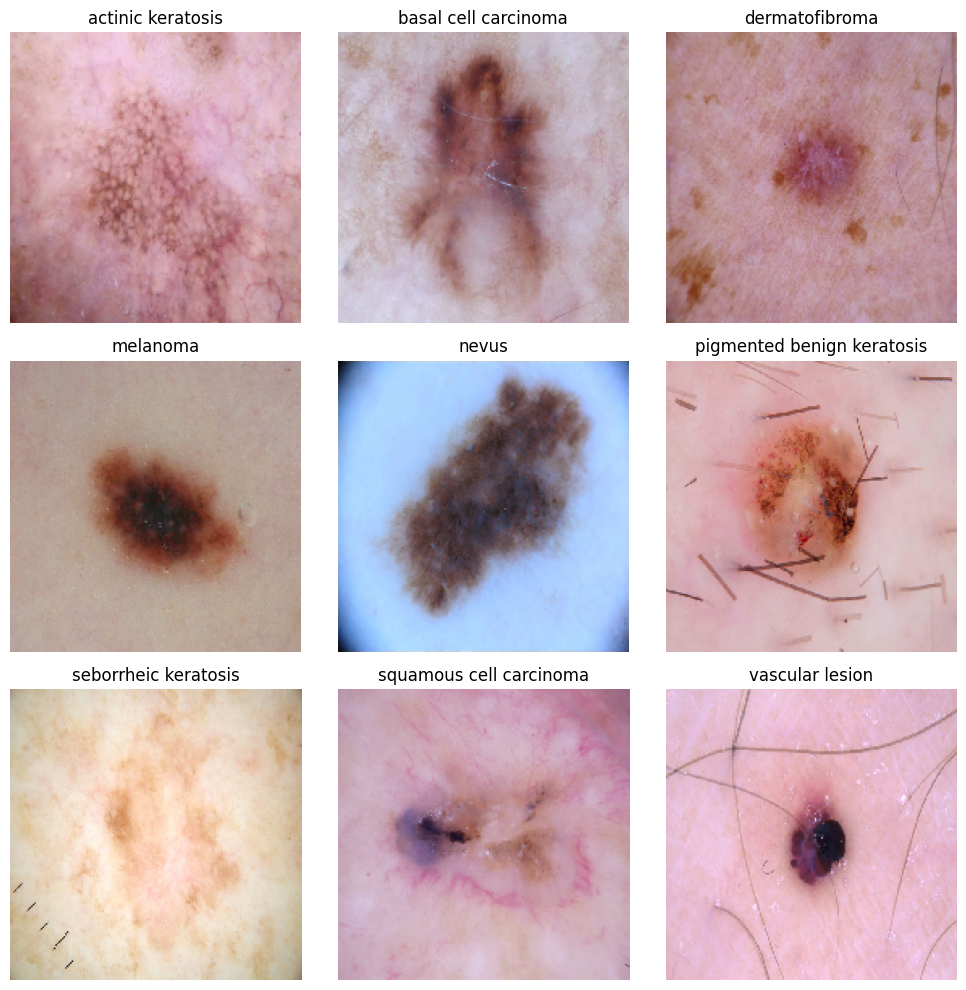

In [12]:
# Visualising one instance of all the nine classes present in the dataset
plt.figure(figsize=(10, 10))
for index, class_name in enumerate(class_names):
    img_path = os.path.join(data_dir_train, class_name, os.listdir(os.path.join(data_dir_train, class_name))[0])
    img = load_img(img_path, target_size=(180, 180))

    plt.subplot(3, 3, index + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Improve Dataset read performance

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h2 style = "color : Brown">Model Building & training</h2>

Creating a CNN model, which can detect 9 classes present in the dataset.

Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network.

Standardizing values to be in the `[0, 1]`

In [14]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout



### Build the model

In [15]:
model1 = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Define input shape here
    Rescaling(1./255),

    # Convolutional and pooling layers
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),  # Flatten layer

    # Dense layers
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),

    # Output layer with softmax activation for classification
    Dense(len(class_names), activation='softmax')
])

### Compile the model


In [16]:
# Choosing 'adam' optimiser and loss function CategoricalCrossentropy since this this is a classification
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,374,985 (100.61 MB)

 Trainable params: 26,374,985 (100.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.2513 - loss: 2.0527 - val_accuracy: 0.3982 - val_loss: 1.6534
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3908 - loss: 1.6857 - val_accuracy: 0.4676 - val_loss: 1.4746
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4766 - loss: 1.4649 - val_accuracy: 0.5436 - val_loss: 1.4100
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4914 - loss: 1.3944 - val_accuracy: 0.5257 - val_loss: 1.3514
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5410 - loss: 1.2874 - val_accuracy: 0.5190 - val_loss: 1.3776
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6040 - loss: 1.1048 - val_accuracy: 0.4676 - val_loss: 1.4608
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5790 - loss: 1.1348 - val_accuracy: 0.5257 - val_loss: 1.5404
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6612 - loss: 0.9764 - val_accuracy: 0.4966 - v

### Visualizing training results

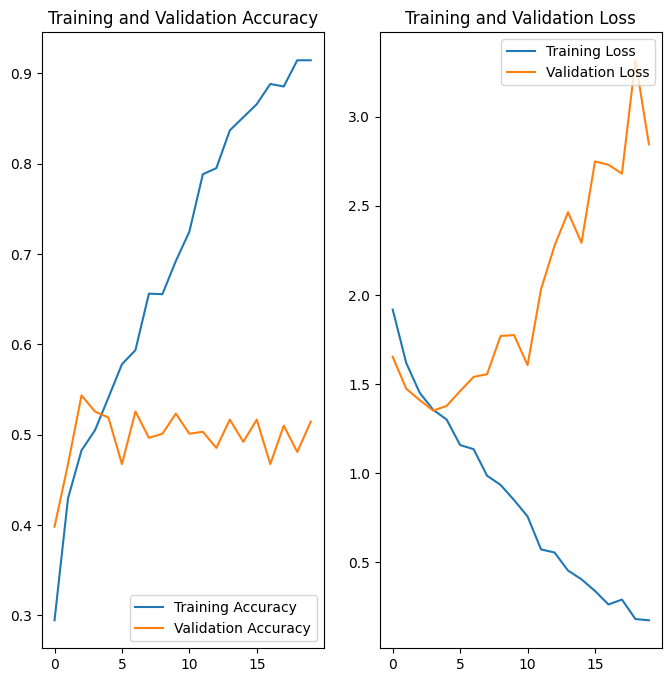

In [20]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inferences


**Training and Validation Accuracy:**

Training Accuracy (blue line) steadily increases over the epochs, reaching close to 0.9.

Validation Accuracy (orange line) shows an initial increase but then fluctuates without significant improvement, staying lower(~0.5) than the training accuracy.

**Training and Validation Loss:**

Training Loss (blue line) consistently decreases, approaching zero.

Validation Loss (orange line) initially decreases but then starts increasing after a few epochs.

**Inferences**

Overfitting: The model appears to be overfitting. This is indicated by the high training accuracy and low training loss, while the validation accuracy stagnates and validation loss increases.

Generalization: The model is not generalizing well to the validation data, which suggests it might be learning the training data too well, including noise and details that do not generalize to new data.



<h2 style = "color : Brown">Data Augumentation</h2>

Let's use data augmentation to increase the diversity of our training data and reduce overfitting

In [21]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

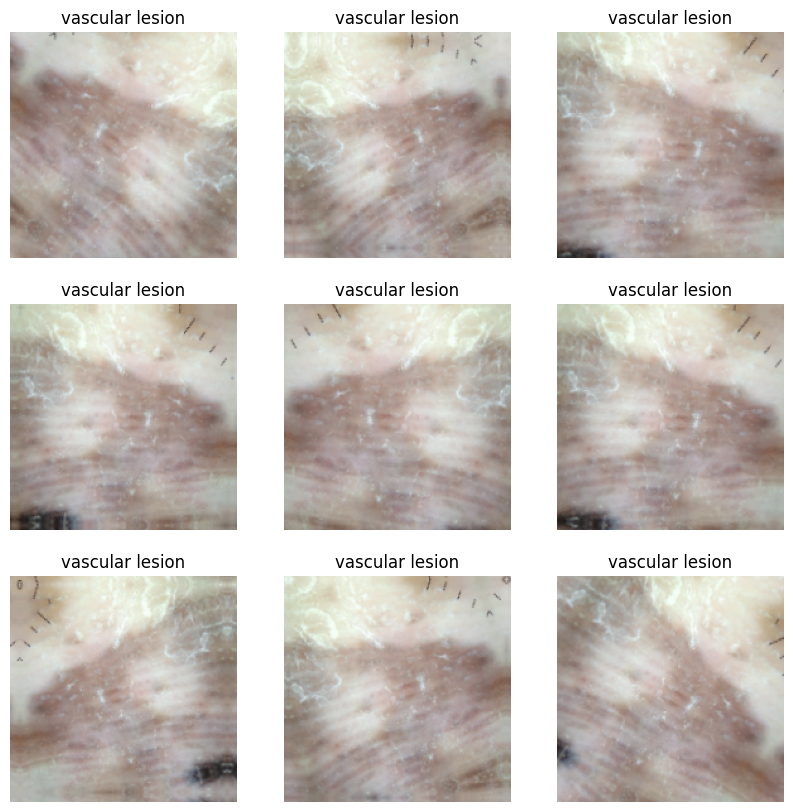

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")

### Create the model


In [23]:
model2 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Rescaling(1./255),

    # adding the augmentation layer
    data_augmentation,

    # Convolutional and pooling layers
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),  # Flatten layer

    # Dense layers
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),

    # Output layer with softmax activation for classification
    Dense(len(class_names), activation='softmax')
])



### Compiling the model

In [24]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,374,985 (100.61 MB)

 Trainable params: 26,374,985 (100.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.2057 - loss: 2.1643 - val_accuracy: 0.4116 - val_loss: 1.6791
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.4200 - loss: 1.6562 - val_accuracy: 0.4743 - val_loss: 1.5113
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4526 - loss: 1.4906 - val_accuracy: 0.4899 - val_loss: 1.4561
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4841 - loss: 1.5027 - val_accuracy: 0.4922 - val_loss: 1.4635
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5366 - loss: 1.3614 - val_accuracy: 0.5056 - val_loss: 1.4175
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5315 - loss: 1.3188 - val_accuracy: 0.5235 - val_loss: 1.3432
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5337 - loss: 1.2928 - val_accuracy: 0.4631 - val_loss: 1.4303
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5228 - loss: 1.3035 - val_accuracy: 0.4720 - v

### Visualizing the results

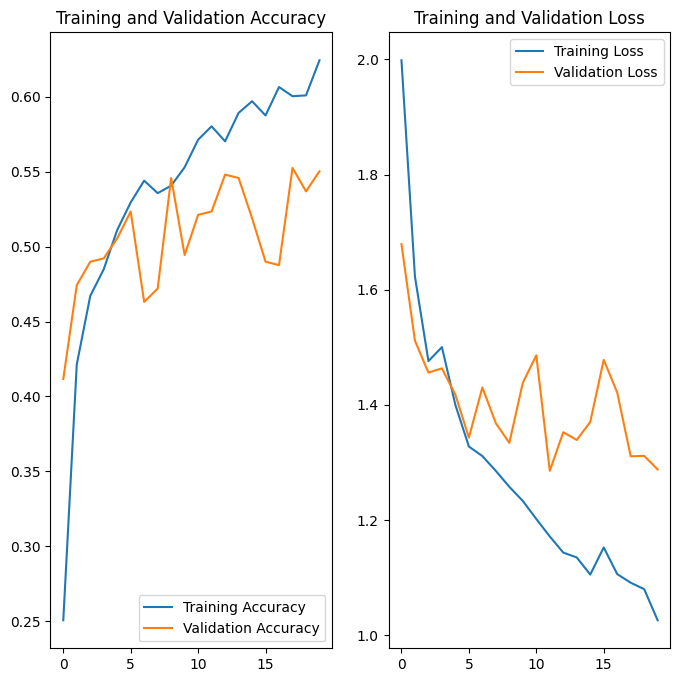

In [27]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inferences:

Validation accuracy is still the same; whereas Training accuracy had dropped to <0.7 There is still overfitting

<h2 style = "color : Brown">Data Augumentation with dropouts</h2>

To help reduce overfitting and improve your model's generalization. Dropout works by randomly setting a fraction of input units to 0 at each update during training time, which helps prevent the model from becoming too reliant on any particular set of neurons.

In [28]:
model3 = Sequential([
    Input(shape=(img_height, img_width, 3)),  # Define input shape here
    Rescaling(1./255),

    # adding the augmentation layer
    data_augmentation,

    # Convolutional and pooling layers
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),


    Flatten(),  # Flatten layer

    # Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout layer with 50% dropout rate
    Dense(128, activation='relu'),
    Dropout(0.5), # Another dropout layer

    # Output layer with softmax activation for classification
    Dense(len(class_names), activation='softmax')
])

In [29]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1728 - loss: 2.5137 - val_accuracy: 0.3154 - val_loss: 1.8537
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.3331 - loss: 1.8646 - val_accuracy: 0.4161 - val_loss: 1.6506
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.3788 - loss: 1.7493 - val_accuracy: 0.4944 - val_loss: 1.5374
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4143 - loss: 1.6117 - val_accuracy: 0.4541 - val_loss: 1.5422
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4196 - loss: 1.5936 - val_accuracy: 0.4899 - val_loss: 1.4556
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4543 - loss: 1.5323 - val_accuracy: 0.4139 - val_loss: 1.6061
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4310 - loss: 1.6022 - val_accuracy: 0.4944 - val_loss: 1.4506
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.4809 - loss: 1.4887 - val_accuracy: 0.5123 - v

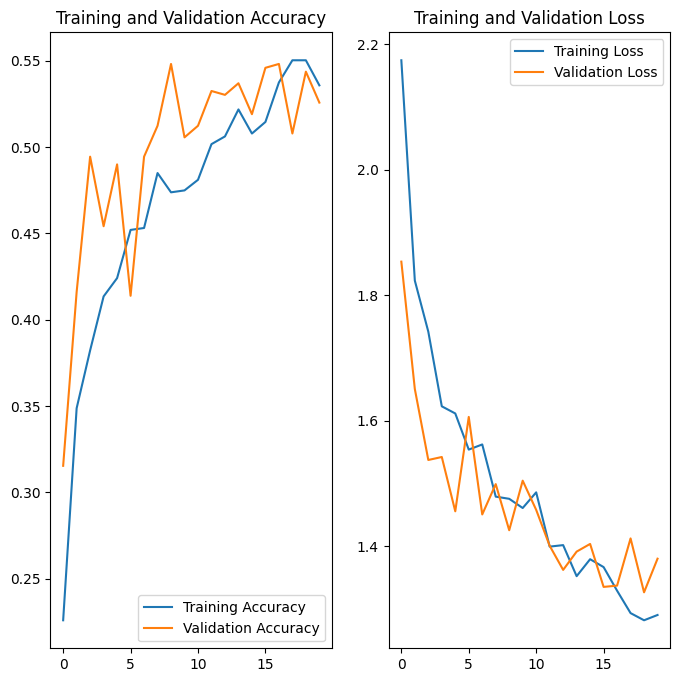

In [32]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference:
Overfitting is reduced; but the accuracy is less, need to focus on Model performance, to improve accuracy


<h2 style = "color : Brown">Class distribution</h2>

In [33]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


 Which class has the least number of samples? seborrheic keratosis (77)

 Which classes dominate the data in terms proportionate number of samples? pigmented benign keratosis (462)


<h2 style = "color : Brown">Handling class imbalances with Augmentor Library</h2>

In [34]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [35]:
path_to_training_dataset="/content/drive/MyDrive/CNN/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A045869FD00>: 100%|██████████| 500/500 [00:23<00:00, 21.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A04587536A0>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A0458527EE0>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A04D9C221A0>: 100%|██████████| 500/500 [01:32<00:00,  5.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7A04D9B57700>: 100%|██████████| 500/500 [01:15<00:00,  6.61 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A04D00AB5E0>: 100%|██████████| 500/500 [00:20<00:00, 24.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A04D9C22380>: 100%|██████████| 500/500 [00:42<00:00, 11.72 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A04D13498A0>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A045865F250>: 100%|██████████| 500/500 [00:21<00:00, 23.79 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500 images to all the 9 classes to maintain some class balance. We can add more images as we want to improve training process.

In [37]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

<h2 style = "color : Brown">Model Building & Training on Rectified class imbalance data</h2>

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
#training Dataset
data_dir_train=pathlib.Path("/content/drive/MyDrive/CNN/Train/")
rectified_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [40]:
# Validation Dataset
rectified_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Creating the model

In [41]:

model4 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Rescaling(1./255),

    # Convolutional and pooling layers
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),  # Flatten layer

    # Dense layers
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),

    # Output layer with softmax activation for classification
    Dense(len(class_names), activation='softmax')
])

#### Compile the model

In [42]:
## your code goes here
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [43]:
epochs = 30
history4 = model4.fit(
  rectified_train_ds,
  validation_data=rectified_val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 268ms/step - accuracy: 0.2162 - loss: 2.0921 - val_accuracy: 0.4336 - val_loss: 1.4930
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.4278 - loss: 1.4892 - val_accuracy: 0.5033 - val_loss: 1.3208
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.5098 - loss: 1.2811 - val_accuracy: 0.5546 - val_loss: 1.2104
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - accuracy: 0.5812 - loss: 1.0935 - val_accuracy: 0.5895 - val_loss: 1.0550
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.6817 - loss: 0.8766 - val_accuracy: 0.6518 - val_loss: 0.9724
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - accuracy: 0.7416 - loss: 0.6960 - val_accuracy: 0.7275 - val_loss: 0.8138
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.8045 - loss: 0.5277 - val_accuracy: 0.7335 - val_loss: 0.7405
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.8304 - loss: 0.4446 - val

#### Visualize the model results

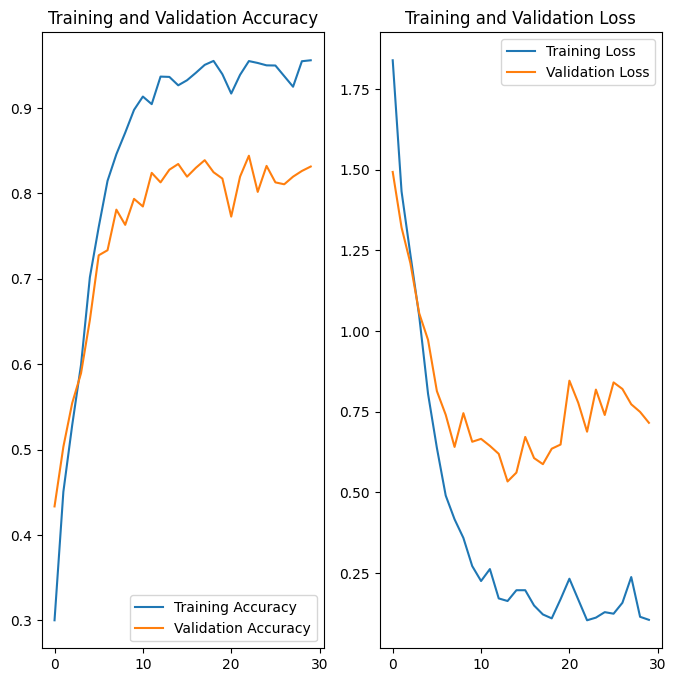

In [44]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Inference

- Overfitting issue has been reduced comparatively, and the accuracy had also improved significantly.